In [40]:
import numpy as np
from matplotlib import pyplot as plt
# ----- Cord for importing .ipynb file as module -----
import sys  
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
# ----------------------------------------------------
from activations import *
from optimizer import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


class lstm_module:
    def __init__(self, layers_dims, init_range):
        self.params = {}
        self.grads = {}
        self.outputs = {}
        self.ld = layers_dims
        self.L = len(layers_dims)
        # Parameters of hidden layers
        for l in range(1, self.L-1):
            U = np.random.uniform(
                low = - init_weight_range,
                high = init_weight_range,
                size = (layers_dims[l-1], layers_dims[l])
            )
            W = np.random.uniform(
                low = - init_weight_range,
                high = init_weight_range,
                size = (layers_dims[l], layers_dims[l])
            )
            b = np.zeros((1, layers_dims[l]))
            self.params['Ua' + str(l)] = U
            self.params['Ui' + str(l)] = U
            self.params['Uo' + str(l)] = U
            self.params['Uf' + str(l)] = U
            self.params['Wa' + str(l)] = W
            self.params['Wi' + str(l)] = W
            self.params['Wo' + str(l)] = W
            self.params['Wf' + str(l)] = W
            self.params['ba' + str(l)] = b
            self.params['bi' + str(l)] = b
            self.params['bo' + str(l)] = b
            self.params['bf' + str(l)] = b
        # Parameters of output layers
        V = np.random.uniform(
            low = - init_weight_range,
            high = init_weight_range,
            size = (layers_dims[self.L-2], layers_dims[self.L-1])
        )
        c = np.zeros((1, layers_dims[self.L-1]))
        self.params['V'] = V                      # Weights of output layer
        self.params['c'] = c                      # Biases of output layer
            
    def forward_propagate(self, X, activations):
        g = activations['output_activation']
        self.N = X.shape[0]
        self.T = X.shape[1]
        # Initialising hidden output
        for l in range(1, self.L-1):
            self.outputs['H' + str(l) + str(self.T)] = np.zeros((self.N, self.ld[l]))
            self.outputs['C' + str(l) + str(self.T)] = np.zeros((self.N, self.ld[l]))
        
        for t in reversed(range(self.T)):
            # Input Layer
            self.outputs['H0' + str(t)] = X[:, t, :]
            # Hidden Layers
            for l in range(1, self.L-1):
                Ua = self.params['Ua' + str(l)]
                Wa = self.params['Wa' + str(l)]
                ba = self.params['ba' + str(l)]
                Ui = self.params['Ui' + str(l)]
                Wi = self.params['Wi' + str(l)]
                bi = self.params['bi' + str(l)]
                Uo = self.params['Uo' + str(l)]
                Wo = self.params['Wo' + str(l)]
                bo = self.params['bo' + str(l)]
                Uf = self.params['Uf' + str(l)]
                Wf = self.params['Wf' + str(l)]
                bf = self.params['bf' + str(l)]
                H_lprev = self.outputs['H' + str(l-1) + str(t)]
                H_tprev = self.outputs['H' + str(l) + str(t+1)]
                C_tprev = self.outputs['C' + str(l) + str(t+1)]
                Za = np.dot(H_lprev, Ua) + np.dot(H_tprev, Wa) + ba
                Zi = np.dot(H_lprev, Ui) + np.dot(H_tprev, Wi) + bi
                Zo = np.dot(H_lprev, Uo) + np.dot(H_tprev, Wo) + bo
                Zf = np.dot(H_lprev, Uf) + np.dot(H_tprev, Wf) + bf
                a = np.tanh(Za)
                i = sigmoid(Zi)
                o = sigmoid(Zo)
                f = sigmoid(Zf)
                C = i * a + f * C_tprev
                H = o * np.tanh(C)
                self.outputs['Za' + str(l) + str(t)] = Za
                self.outputs['Zi' + str(l) + str(t)] = Zi
                self.outputs['Zo' + str(l) + str(t)] = Zo
                self.outputs['Zf' + str(l) + str(t)] = Zf
                self.outputs['a' + str(l) + str(t)] = a
                self.outputs['i' + str(l) + str(t)] = i
                self.outputs['o' + str(l) + str(t)] = o
                self.outputs['f' + str(l) + str(t)] = f
                self.outputs['C' + str(l) + str(t)] = C
                self.outputs['H' + str(l) + str(t)] = H
            # Output Layer
            V = self.params['V']
            c = self.params['c']
            Z = np.dot(H, V) + c
            A = g(Z)
            self.outputs['Z' + str(self.L-1) + str(t)] = Z
            self.outputs['A' + str(t)] = A
        
    def compute_loss(self, Y):
        A = self.outputs['A0']
        # ==============================================================
        # Mean square error
        loss = np.sum(np.square(A - Y)) / self.N
        
        # Cross entoropy loss
#         loss = - np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / m
        loss = np.squeeze(loss)
        # ==============================================================
        # --------------------------------------------------------------
        assert(loss.shape == ())
        # --------------------------------------------------------------
        return loss
    
    def back_propagate(self, Y, activations):
        dg = activations['derivative_output_activation']
        # Output Layer
        A = self.outputs['A0']
        Z = self.outputs['Z' + str(self.L-1) + '0']
        H_prev = self.outputs['H' + str(self.L-2) + '0']
        # ==============================================================
        # Mean square error
        dA = (A - Y) / self.N
        # Cross entropy loss
#         dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A)) / self.N
        # ==============================================================
        dZ = dA * dg(Z)
        dV = np.dot(H_prev.T, dZ)
        dc = np.sum(dZ, axis = 0, keepdims = True)
        # --------------------------------------------------------------
        assert(dV.shape == self.params['V'].shape)
        assert(dc.shape == self.params['c'].shape)
        # --------------------------------------------------------------
        self.grads['V'] = dV
        self.grads['c'] = dc
        dH_th_layer = np.dot(dZ, self.params['V'].T)

        # Hidden Layers
        for l in reversed(range(1, self.L-1)):
            # Define necessary paramiters
            dUa = np.zeros(self.params['Ua' + str(l)].shape)
            dWa = np.zeros(self.params['Wa' + str(l)].shape)
            dba = np.zeros(self.params['ba' + str(l)].shape)
            dUi = np.zeros(self.params['Ui' + str(l)].shape)
            dWi = np.zeros(self.params['Wi' + str(l)].shape)
            dbi = np.zeros(self.params['bi' + str(l)].shape)
            dUo = np.zeros(self.params['Uo' + str(l)].shape)
            dWo = np.zeros(self.params['Wo' + str(l)].shape)
            dbo = np.zeros(self.params['bo' + str(l)].shape)
            dUf = np.zeros(self.params['Uf' + str(l)].shape)
            dWf = np.zeros(self.params['Wf' + str(l)].shape)
            dbf = np.zeros(self.params['bf' + str(l)].shape)
            Ua = self.params['Ua' + str(l)]
            Ui = self.params['Ui' + str(l)]
            Uo = self.params['Uo' + str(l)]
            Uf = self.params['Uf' + str(l)]
            Wa = self.params['Wa' + str(l)]
            Wi = self.params['Wi' + str(l)]
            Wo = self.params['Wo' + str(l)]
            Wf = self.params['Wf' + str(l)]
            # t = t
            # Define necessary outputs
            a = self.outputs['a' + str(l) + '0']
            i = self.outputs['i' + str(l) + '0']
            o = self.outputs['o' + str(l) + '0']
            f = self.outputs['f' + str(l) + '0']
            Za = self.outputs['Za' + str(l) + '0']
            Zi = self.outputs['Zi' + str(l) + '0']
            Zo = self.outputs['Zo' + str(l) + '0']
            Zf = self.outputs['Zf' + str(l) + '0']
            C = self.outputs['C' + str(l) + '0']
            C_tprev = self.outputs['C' + str(l) + '1']
            H_tprev = self.outputs['H' + str(l) + '1']
            H_lprev = self.outputs['H' + str(l-1) + '0']
            # Calculate necessary gradients
            dC = dH_th_layer * o * d_tanh(C)
            do = dH_th_layer * np.tanh(C)
            da = dC * i
            df = dC * C_tprev
            di = dC * a
            dZa = da * d_tanh(Za)
            dZi = di * d_sigmoid(Zi)
            dZo = do * d_sigmoid(Zo)
            dZf = df * d_sigmoid(Zf)
            # Sum each paramiter gradient
            dUa += np.dot(H_lprev.T, dZa)
            dWa += np.dot(H_tprev.T, dZa)
            dba += np.sum(dZa, axis = 0, keepdims = True)
            dUi += np.dot(H_lprev.T, dZi)
            dWi += np.dot(H_tprev.T, dZi)
            dbi += np.sum(dZi, axis = 0, keepdims = True)
            dUo += np.dot(H_lprev.T, dZo)
            dWo += np.dot(H_tprev.T, dZo)
            dbo += np.sum(dZo, axis = 0, keepdims = True)
            dUf += np.dot(H_lprev.T, dZf)
            dWf += np.dot(H_tprev.T, dZf)
            dbf += np.sum(dZf, axis = 0, keepdims = True)
            # Calcurate each gradient of H & C through time     
            da_Ht = np.dot(d_sigmoid(Za), Wa.T)
            di_Ht = np.dot(d_sigmoid(Zi), Wi.T)
            do_Ht = np.dot(d_sigmoid(Zo), Wo.T)
            df_Ht = np.dot(d_sigmoid(Zf), Wf.T)
            dC_Ht = np.dot(di_Ht.T, a) + np.dot(da_Ht.T, i) + np.dot(df_Ht.T, C_tprev)
            dgC_Ht = np.dot(d_tanh(C), dC_Ht.T)
            dW_Ht = np.dot(do_Ht.T, np.tanh(C)) + np.dot(dgC_Ht.T, o)
            dH_th_time = np.dot(dH_th_layer, dW_Ht.T)
            dC_th_time = dC * f
            # Calcurate gradients of H through layer
            da_Hl = np.dot(d_tanh(Za), Ua.T)
            di_Hl = np.dot(d_sigmoid(Zi), Ui.T)
            do_Hl = np.dot(d_sigmoid(Zo), Uo.T)
            df_Hl = np.dot(d_sigmoid(Zf), Uf.T)
            dC_Hl = np.dot(di_Hl.T, a) + np.dot(da_Hl.T, i) + np.dot(df_Hl.T, C_tprev)
            dgC_Hl = np.dot(d_tanh(C), dC_Hl.T)
            dU_Hl = np.dot(do_Hl.T, C) + np.dot(dgC_Hl.T, o)
            dH_th_layer = np.dot(dH_th_layer, dU_Hl.T)
            # t = t-1 ~ t-T
            for t in range(1, self.T-1):
                # Define necessary outputs
                a = self.outputs['a' + str(l) + str(t)]
                i = self.outputs['i' + str(l) + str(t)]
                o = self.outputs['o' + str(l) + str(t)]
                f = self.outputs['f' + str(l) + str(t)]
                Za = self.outputs['Za' + str(l) + str(t)]
                Zi = self.outputs['Zi' + str(l) + str(t)]
                Zo = self.outputs['Zo' + str(l) + str(t)]
                Zf = self.outputs['Zf' + str(l) + str(t)]
                C = self.outputs['C' + str(l) + str(t)]
                C_tprev = self.outputs['C' + str(l) + str(t-1)]
                H_tprev = self.outputs['H' + str(l) + str(t-1)]
                H_lprev = self.outputs['H' + str(l-1) + str(t)]
                # Calculate necessary gradients
                do = dH_th_time * np.tanh(C)
                da = dC_th_time * i
                df = dC_th_time * C_tprev
                di = dC_th_time * a
                dZa = da * d_tanh(Za)
                dZi = di * d_sigmoid(Zi)
                dZo = do * d_sigmoid(Zo)
                dZf = df * d_sigmoid(Zf)
                # Sum each paramiter gradient
                dUa += np.dot(H_lprev.T, dZa)
                dWa += np.dot(H_tprev.T, dZa)
                dba += np.sum(dZa, axis = 0, keepdims = True)
                dUi += np.dot(H_lprev.T, dZi)
                dWi += np.dot(H_tprev.T, dZi)
                dbi += np.sum(dZi, axis = 0, keepdims = True)
                dUo += np.dot(H_lprev.T, dZo)
                dWo += np.dot(H_tprev.T, dZo)
                dbo += np.sum(dZo, axis = 0, keepdims = True)
                dUf += np.dot(H_lprev.T, dZf)
                dWf += np.dot(H_tprev.T, dZf)
                dbf += np.sum(dZf, axis = 0, keepdims = True)
                # Calcurate each gradient of H & C through time
                da_Ht = np.dot(d_sigmoid(Za), Wa.T)
                di_Ht = np.dot(d_sigmoid(Zi), Wi.T)
                do_Ht = np.dot(d_sigmoid(Zo), Wo.T)
                df_Ht = np.dot(d_sigmoid(Zf), Wf.T)
                dC_Ht = np.dot(di_Ht.T, a) + np.dot(da_Ht.T, i) + np.dot(df_Ht.T, C_tprev)
                dgC_Ht = np.dot(d_tanh(C), dC_Ht.T)
                dW_Ht = np.dot(do_Ht.T, np.tanh(C)) + np.dot(dgC_Ht.T, o)
                dH_th_time = np.dot(dH_th_time, dW_Ht.T)
                dC_th_time = dC_th_time * f
            # ----------------------------------------------------------
            assert(dUa.shape == self.params['Ua' + str(l)].shape)
            assert(dWa.shape == self.params['Wa' + str(l)].shape)
            assert(dba.shape == self.params['ba' + str(l)].shape)
            assert(dUi.shape == self.params['Ui' + str(l)].shape)
            assert(dWi.shape == self.params['Wi' + str(l)].shape)
            assert(dbi.shape == self.params['bi' + str(l)].shape)
            assert(dUo.shape == self.params['Uo' + str(l)].shape)
            assert(dWo.shape == self.params['Wo' + str(l)].shape)
            assert(dbo.shape == self.params['bo' + str(l)].shape)
            assert(dUf.shape == self.params['Uf' + str(l)].shape)
            assert(dWf.shape == self.params['Wf' + str(l)].shape)
            assert(dbf.shape == self.params['bf' + str(l)].shape)
            # ----------------------------------------------------------
            self.grads['Ua' + str(l)] = dUa
            self.grads['Wa' + str(l)] = dWa
            self.grads['ba' + str(l)] = dba
            self.grads['Ui' + str(l)] = dUi
            self.grads['Wi' + str(l)] = dWi
            self.grads['bi' + str(l)] = dbi
            self.grads['Uo' + str(l)] = dUo
            self.grads['Wo' + str(l)] = dWo
            self.grads['bo' + str(l)] = dbo
            self.grads['Uf' + str(l)] = dUf
            self.grads['Wf' + str(l)] = dWf
            self.grads['bf' + str(l)] = dbf

    def test_lstm(self, X, activations):
        g = activations['output_activation']
        self.N = X.shape[0]
        self.T = X.shape[1]
        # Initialising hidden output
        for l in range(1, self.L-1):
            self.outputs['H' + str(l) + str(self.T)] = np.zeros((self.N, self.ld[l]))
            self.outputs['C' + str(l) + str(self.T)] = np.zeros((self.N, self.ld[l]))
        for t in reversed(range(self.T)):
            # Input Layer
            self.outputs['H0' + str(t)] = X[:, t, :]
            # Hidden Layers
            for l in range(1, self.L-1):
                Ua = self.params['Ua' + str(l)]
                Wa = self.params['Wa' + str(l)]
                ba = self.params['ba' + str(l)]
                Ui = self.params['Ui' + str(l)]
                Wi = self.params['Wi' + str(l)]
                bi = self.params['bi' + str(l)]
                Uo = self.params['Uo' + str(l)]
                Wo = self.params['Wo' + str(l)]
                bo = self.params['bo' + str(l)]
                Uf = self.params['Uf' + str(l)]
                Wf = self.params['Wf' + str(l)]
                bf = self.params['bf' + str(l)]
                H_lprev = self.outputs['H' + str(l-1) + str(t)]
                H_tprev = self.outputs['H' + str(l) + str(t+1)]
                C_tprev = self.outputs['C' + str(l) + str(t+1)]
                Za = np.dot(H_lprev, Ua) + np.dot(H_tprev, Wa) + ba
                Zi = np.dot(H_lprev, Ui) + np.dot(H_tprev, Wi) + bi
                Zo = np.dot(H_lprev, Uo) + np.dot(H_tprev, Wo) + bo
                Zf = np.dot(H_lprev, Uf) + np.dot(H_tprev, Wf) + bf
                a = np.tanh(Za)
                i = sigmoid(Zi)
                o = sigmoid(Zo)
                f = sigmoid(Zf)
                C = i * a + f * C_tprev
                H = o * np.tanh(C)
                self.outputs['C' + str(l) + str(t)] = C
                self.outputs['H' + str(l) + str(t)] = H
            # Output Layer
            V = self.params['V']
            c = self.params['c']
            Z = np.dot(H, V) + c
            A = g(Z)
        return A

(176, 25, 1)
Epoch: 1   Train Loss: 0.4266   Test Loss: 0.5852
Epoch: 100   Train Loss: 0.0239   Test Loss: 0.0375
Epoch: 200   Train Loss: 0.0137   Test Loss: 0.0118
Epoch: 300   Train Loss: 0.0015   Test Loss: 0.0013
Epoch: 400   Train Loss: 0.0029   Test Loss: 0.0019
Epoch: 500   Train Loss: 0.0013   Test Loss: 0.0016
Epoch: 600   Train Loss: 0.0013   Test Loss: 0.0011
Epoch: 700   Train Loss: 0.0150   Test Loss: 0.0057
Epoch: 800   Train Loss: 0.0008   Test Loss: 0.0011
Epoch: 900   Train Loss: 0.0010   Test Loss: 0.0011
Epoch: 1000   Train Loss: 0.0008   Test Loss: 0.0011


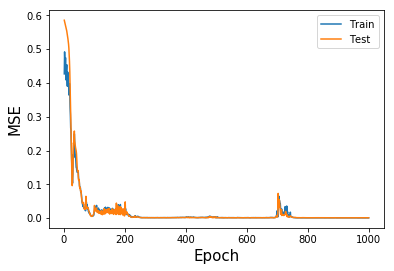

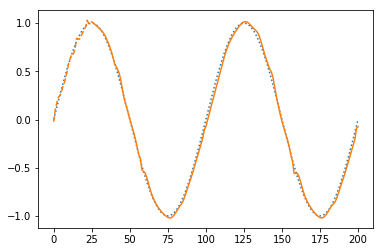

In [46]:
# -------------------< Toy Problem(Predict sin wave) >-------------------
if  __name__ == '__main__':
    def toy_problem(T = 100, A = 0.05):
        x = np.arange(0, 2 * T + 1)
        noise = A * np.random.uniform(low = - 1.0, high = 1.0, size = len(x))
        return np.sin(2.0 * np.pi * x / T) + noise
    
    # Prepare sin wave data
    T = 100
    f = toy_problem(T)
    seq_len = 25
    data = []
    target = []
    for t in range(2 * T - seq_len + 1):
        data.append(f[t: t + seq_len])
        target.append(f[t + seq_len])
    
    # Set up networks
    layer_dims = [1, 20, 1]
    init_weight_range = 0.3
    lstm = lstm_module(layer_dims, init_weight_range)
    activations = return_activations(name_haf = 'tanh', name_oaf = 'linear')
    lr = 0.1
#     optimizer = SGD(lstm, lr)
    optimizer = Adam(lstm)

    # Create train and teach data
    X = np.array(data).reshape(len(data), seq_len, layer_dims[0])
    Y = np.array(target).reshape(len(target), layer_dims[-1])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
    print(X.shape)
    
    # Learning data
    epoches = 1000
    batch_size = 32
    Loss_train = []
    Loss_test = []
    n_batches = len(X_train) // batch_size
    for epoch in range(1, epoches + 1):
        loss_list = []
        X_train, Y_train = shuffle(X_train, Y_train)
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            lstm.forward_propagate(X_train[start:end], activations)
            loss_list.append(lstm.compute_loss(Y_train[start:end]))
            lstm.back_propagate(Y_train[start:end], activations)
            optimizer.update_params()
        Loss_train.append(np.mean(loss_list))
        lstm.forward_propagate(X_test, activations)
        Loss_test.append(lstm.compute_loss(Y_test))
        if epoch % 100 == 0 or epoch == 1:
            print('Epoch:', epoch,
                  '  Train Loss:', '{:.4f}'.format(Loss_train[-1]),
                  '  Test Loss:', '{:.4f}'.format(Loss_test[-1])
                 )
    
    # Plot Learning Curve
    plt.figure()
    plt.plot(np.arange(epoches) + 1, Loss_train, label='Train')
    plt.plot(np.arange(epoches) + 1, Loss_test, label='Test')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('MSE', fontsize=15)
    plt.legend()
    
    # Plot predicted sin wave
    Z = X[:1]
    original = [f[t] for t in range(seq_len)]
    predicted = [None for t in range(seq_len)]
    for t in range(2 * T - seq_len + 1):
        z = Z[-1:]
        y_pred = lstm.test_lstm(z, activations)
        sequence = np.concatenate(
            (z.reshape(seq_len, layer_dims[0])[1:], y_pred)
        ).reshape(1, seq_len, layer_dims[0])
        Z = np.append(Z, sequence, axis=0)
        predicted.append(float(y_pred))
    plt.figure()
    plt.plot(toy_problem(T, A=0), linestyle='dotted', color='tab:blue')
    plt.plot(original, linestyle='dashed', color='tab:orange')
    plt.plot(predicted, color='tab:orange')